In [1]:
import torch
from time import time

a = torch.ones(1000)
b = torch.ones(1000)

start = time()
c = torch.zeros(1000)
for i in range(1000):
    c[i] = a[i] + b[i]
print(time() - start)

0.03400611877441406


In [2]:
start = time()
d = a + b
print(time() - start)

0.0009987354278564453


# 线性回归的从零开始实现

In [3]:
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random


生成数据集

In [4]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.from_numpy(np.random.normal(0, 1, (num_examples, num_inputs)))
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b

labels += torch.from_numpy(np.random.normal(0, 0.01, size=labels.size())) # 随机噪声

print(features[0], labels[0])

tensor([2.9077, 1.9485], dtype=torch.float64) tensor(3.3674, dtype=torch.float64)


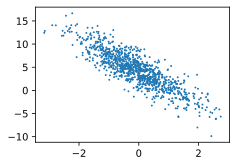

In [5]:
def use_svg_display():
    display.set_matplotlib_formats('svg')

def set_figsize(figsize = (3.5, 2.5)):
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

set_figsize()
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1)

读取数据

In [6]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)])
        yield features.index_select(0, j), labels.index_select(0, j)

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break

tensor([[ 0.2877, -0.1175],
        [ 0.9347,  0.4947],
        [-0.2788,  1.6589],
        [ 0.6901, -0.0254],
        [ 1.6761, -1.0953],
        [ 0.8964,  0.4014],
        [ 1.5864, -1.1667],
        [ 0.2101, -1.2739],
        [ 1.3577,  0.2752],
        [ 0.1911, -1.1308]], dtype=torch.float64) tensor([ 5.1793,  4.3828, -2.0043,  5.6592, 11.2790,  4.6202, 11.3267,  8.9443,
         5.9834,  8.4239], dtype=torch.float64)


初始化模型参数

In [7]:
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)

w.requires_grad_(requires_grad = True)
b.requires_grad_(requires_grad = True)

tensor([0.], requires_grad=True)

定义模型

In [12]:
def linreg(X, w, b):
    X = torch.tensor(X, dtype=torch.float32)
    return torch.mm(X, w) + b

定义损失函数

In [9]:
def squared_loss(y_hat, y):
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

定义优化算法

In [10]:
def sgd(params, lr, batch_size):
    for param in params:
        param.data -= lr * param.grad / batch_size

训练模型

In [13]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = squared_loss(net(X, w, b), y).sum()
        l.backward()
        sgd([w, b], lr, batch_size)

        w.grad.data.zero_()
        b.grad.data.zero_()
    
    train_l = squared_loss(net(features, w, b), labels)
    print('epoch %d, loss %f ' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 0.029430 
epoch 2, loss 0.000105 
epoch 3, loss 0.000050 


In [14]:
print(true_w, '\n', w)
print(true_b, '\n', b)

[2, -3.4] 
 tensor([[ 1.9994],
        [-3.4002]], requires_grad=True)
4.2 
 tensor([4.1993], requires_grad=True)


# 线性回归的简洁实现

生成数据集

In [15]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.tensor(np.random.normal(0, 1, (num_examples, num_inputs)), dtype=torch.float)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

读取数据

Pytorch提供了data包来读取数据，由于data常用作变量名，我们将导入的data模块用Data代替

In [16]:
import torch.utils.data as Data

batch_size = 10
dataset = Data.TensorDataset(features, labels)
data_iter = Data.DataLoader(dataset, batch_size, shuffle=True)

for X, y in data_iter:
    print(X, y)
    break

tensor([[-0.6800,  0.2318],
        [ 0.5847, -1.9443],
        [-0.2107,  0.3812],
        [ 0.3377,  0.0371],
        [ 2.3318, -0.7826],
        [-1.4996, -0.4230],
        [ 1.2284,  2.2677],
        [ 2.7229,  1.1625],
        [ 1.3908,  0.3026],
        [-2.2081, -1.1457]]) tensor([ 2.0515, 11.9681,  2.4810,  4.7597, 11.5224,  2.6450, -1.0564,  5.6966,
         5.9695,  3.6839])


定义模型

In [17]:
import torch.nn as nn
class LinearNet(nn.Module):
    def __init__(self, n_feature):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(n_feature, 1)
    
    def forward(self, x):
        y = self.linear(x)
        return y

net = LinearNet(num_inputs)
print(net)

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


In [18]:
#  写法一
net = nn.Sequential(
    nn.Linear(num_inputs, 1)
    # 此处还可以传入其他层
    )

# 写法二
net = nn.Sequential()
net.add_module('linear', nn.Linear(num_inputs, 1))

# 写法三
from collections import OrderedDict
net = nn.Sequential(OrderedDict([
    ('linear', nn.Linear(num_inputs, 1))
    # ......
]))

print(net)
print(net[0])

Sequential(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
Linear(in_features=2, out_features=1, bias=True)


In [19]:
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[-0.5164,  0.5847]], requires_grad=True)
Parameter containing:
tensor([-0.4606], requires_grad=True)


初始化模型参数

In [20]:
from torch.nn import init

init.normal_(net[0].weight, mean=0, std=0.01)
init.constant_(net[0].bias, val=0)

Parameter containing:
tensor([0.], requires_grad=True)

定义损失函数

In [21]:
loss = nn.MSELoss()

定义优化算法

In [22]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.03)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)


可以为不同子网络设置不同的学习率

In [ ]:
optimizer = optim.SGD([
    {'params': net.subnet1.parameters()},
    {'params': net.subnet2.parameters(), 'lr': 0.01}
], lr=0.03)

In [ ]:
# 调整学习率
for param_group in optimizer.param_groups:
    param_group['lr'] *= 0.1

训练模型

In [23]:
num_epochs = 3
for epoch in range(1, num_epochs + 1):
    for X, y in data_iter:
        output = net(X)
        l = loss(output, y.view(-1, 1))
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    print('epoch %d, loss: %f' % (epoch, l.item()))

epoch 1, loss: 0.000171
epoch 2, loss: 0.000183
epoch 3, loss: 0.000216


In [24]:
dense = net[0]
print(true_w, dense.weight)
print(true_b, dense.bias)

[2, -3.4] Parameter containing:
tensor([[ 1.9999, -3.4000]], requires_grad=True)
4.2 Parameter containing:
tensor([4.2002], requires_grad=True)
